In [154]:
import tensorflow as tf
from tensorflow.keras import utils
import matplotlib.pyplot as plt

# Generative adversarial network

In [155]:
NOISE_PARAM = 0.1
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002

In [156]:
train_data = utils.image_dataset_from_directory(
    "../data/lego/dataset",labels=None,
    color_mode="grayscale",
    image_size=(64,64),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear"
)

Found 40000 files belonging to 1 classes.


In [157]:
def preprocess(img):
    img = (tf.cast(img,"float32")-127.5)/127.5
    return img

In [158]:
train = train_data.map(lambda x:preprocess(x))

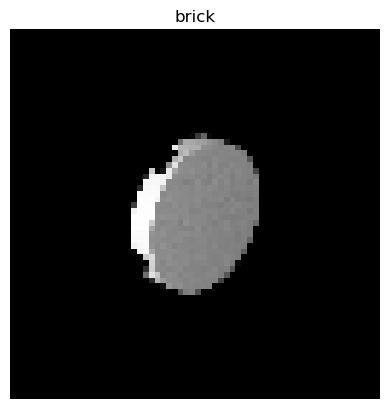

In [159]:
img = train_data.take(1).get_single_element()[0]

fig = plt.subplot()
fig.axis("off")
fig.set_title("brick")
fig.imshow(img,cmap="gray")
plt.show()


In [160]:
from tensorflow.keras import layers,models

# Discriminator

In [161]:
discriminator_input = layers.Input(shape=(64,64,1),name="discriminator_input")

x = layers.Conv2D(64,kernel_size=4,strides=2,padding="same",use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,kernel_size=4,strides=2,padding="same",use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256,kernel_size=4,strides=2,padding="same",use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512,kernel_size=4,strides=2,padding="same",use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1,kernel_size=4,strides=1,padding="valid",use_bias=False,activation="sigmoid")(x)

discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input,discriminator_output)
discriminator.summary()



Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 64, 64, 1)]       0         
 Layer)                                                          
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_40 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_58 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                        

# Generator

In [162]:
generator_input = layers.Input(shape=(100,))
x = layers.Reshape((1,1,100))(generator_input)

x = layers.Conv2DTranspose(512,kernel_size=4,strides=1,padding="valid",use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding="same",use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding="same",use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64,kernel_size=4,strides=2,padding="same",use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(1,kernel_size=4,strides=2,padding="same",use_bias=False,activation="tanh")(x)

generator = models.Model(generator_input,generator_output)
generator.summary()



Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape_7 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_35 (Conv2  (None, 4, 4, 512)         819200    
 DTranspose)                                                     
                                                                 
 batch_normalization_61 (Ba  (None, 4, 4, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_36 (Conv2  (None, 8, 8, 256)         209

In [163]:
from tensorflow.keras import losses,metrics,optimizers

# DCGAN

In [164]:
class DCGAN(models.Model):
    def __init__(self,my_generator,my_discriminator,latent_dim):
        super(DCGAN,self).__init__()
        self.generator = my_generator
        self.discriminator = my_discriminator
        self.latent_dim = latent_dim
        self.g_optimizer = None
        self.loss_fn = None
        self.g_loss_metric = None
        self.d_optimizer = None
        self.d_loss_metric = None
    
    def compile(self,g_optimizer,d_optimizer):
        super(DCGAN,self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.d_loss_metric = metrics.Mean(name="d_loss")
        
    @property
    def metrics(self):
        return [self.g_loss_metric,self.d_loss_metric]
    
    def train_step(self, reals_images):
        batch_size = tf.shape(reals_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
        with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors,training=True)
            
            real_predictions = self.discriminator(reals_images,training=True)
            fake_predictions = self.discriminator(generated_images,training=True)
            
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)


        return {m.name: m.result() for m in self.metrics}

In [165]:
dcgan = DCGAN(generator,discriminator,100)
dcgan.compile(
    d_optimizer=optimizers.legacy.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.legacy.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [166]:
hist = dcgan.fit(train,epochs=2)

Epoch 1/2
313/313 [==============================] - 463s 1s/step - g_loss: 5.2361 - d_loss: 0.1568
Epoch 2/2
313/313 [==============================] - 519s 2s/step - g_loss: 4.9546 - d_loss: 0.0288


In [ ]:
dcgan.save("dcgan.keras")

In [168]:
number_of_images = 5
noise_vectors = tf.random.normal(shape=(number_of_images,100))
print(noise_vectors.shape)


(5, 100)


In [169]:
predictions = generator.predict(noise_vectors)

1/1 [==============================] - 0s 134ms/step


In [170]:
predictions.shape

(5, 64, 64, 1)

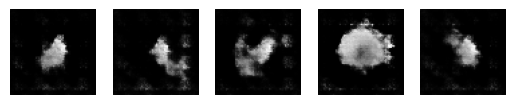

In [171]:
fig,axs = plt.subplots(1,5)

for i in range(5):
    axs[i].imshow(predictions[i],cmap="gray")
    axs[i].axis("off")
plt.show()
    
        

In [172]:
print(hist.history)

{'g_loss': [5.236103534698486, 4.954635143280029], 'd_loss': [0.15681545436382294, 0.028751444071531296]}


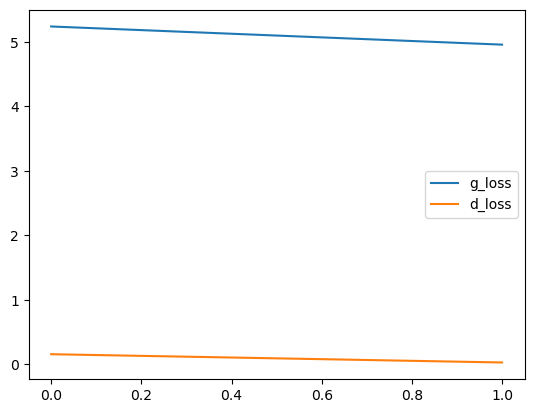

In [173]:
plt.plot(hist.history["g_loss"],label="g_loss")
plt.plot(hist.history["d_loss"],label="d_loss")
plt.legend()
plt.show()